In [13]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

#### Récupérer le dataset sans données manquantes

In [14]:
dataframe = pd.read_csv('C:/Users/Elisée/Desktop/P4/df.csv')
df = dataframe.copy()
df = df.drop(['Unnamed: 0'],axis=1)
df = df.drop(['DefaultData'],axis=1)

In [15]:
#les deux targuet : 
# TotalGHGEmissions & SiteEnergyUse(kBtu)

#### Variables inutiles ou uniques

In [16]:
df = df.drop(['OSEBuildingID','Address','City','State','TaxParcelIdentificationNumber','ListOfAllPropertyUseTypes',
             'PropertyName','SourceEUI(kBtu/sf)','PropertyGFATotal','TotalGHGEmissions'],axis=1) #SiteEnergyUse(kBtu)

#### log

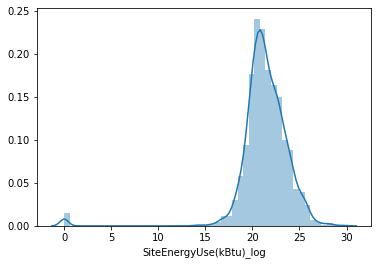

In [17]:
df['SiteEnergyUse(kBtu)_log'] = np.log2(1+df['SiteEnergyUse(kBtu)']) #TotalGHGEmissions
df = df.drop(['SiteEnergyUse(kBtu)'],axis=1)
sns.distplot(df['SiteEnergyUse(kBtu)_log'])

#### FEATURE engenering

In [18]:
df['AgeBat'] = df['DataYear']-df['YearBuilt']
df = df.drop(['DataYear','YearBuilt'],axis=1)


#créer 3 colonne avec des 0
df['most_use_steam'] = 0
df['most_use_natural'] = 0
df['most_use_electric'] = 0

### l'énergie qui est la plus utilisé (electrcité/natural/streamuse), rajouter 1 dans la colonne si c'est l'energie la plus utilisé
df.loc [(df['SteamUse(kBtu)'] > df['Electricity(kBtu)']) & (df['SteamUse(kBtu)'] > df['NaturalGas(kBtu)']),'most_use_steam'] = 1
df.loc [(df['NaturalGas(kBtu)'] > df['Electricity(kBtu)']) & (df['NaturalGas(kBtu)'] > df['SteamUse(kBtu)']),'most_use_natural'] = 1
df.loc [(df['Electricity(kBtu)'] > df['NaturalGas(kBtu)']) & (df['Electricity(kBtu)'] > df['SteamUse(kBtu)']),'most_use_electric'] = 1

# quels sont les énergies utilisés
df.loc [df ['SteamUse(kBtu)'] == 0, 'SteamUse(kBtu)'] = 0
df.loc [df ['SteamUse(kBtu)'] != 0, 'SteamUse(kBtu)'] = 1
df.loc [df ['Electricity(kBtu)'] == 0, 'Electricity(kBtu)'] = 0
df.loc [df ['Electricity(kBtu)'] != 0, 'Electricity(kBtu)'] = 1
df.loc [df ['NaturalGas(kBtu)'] == 0, 'NaturalGas(kBtu)'] = 0
df.loc [df ['NaturalGas(kBtu)'] != 0, 'NaturalGas(kBtu)'] = 1

### renommer pour ne pas croire que j'utilise des données fuites
df = df.rename(columns = {'SteamUse(kBtu)': 'use_stream', 'Electricity(kBtu)': 'use_electricity',
                     'NaturalGas(kBtu)':'use_natural'})
#df=df.drop(['SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)'],axis=1)

#### Supprimer les données fuites 

In [19]:
df = df.drop(['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)','NaturalGas(therms)','GHGEmissionsIntensity',
            'SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu)','Electricity(kWh)'],axis=1)

In [20]:
df_final = df.copy()

In [21]:
pd.set_option('display.max_columns', 31)

In [22]:
df.head()

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,use_stream,use_electricity,use_natural,ComplianceStatus,Latitude,Longitude,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,LargestPropertyUseTypeGFA,SiteEnergyUse(kBtu)_log,AgeBat,most_use_steam,most_use_natural,most_use_electric
0,NonResidential,Large Office,7,DOWNTOWN,1.0,6.0,25920,146922,Office,Data Center,0.0,1.0,1.0,Compliant,47.606016,-122.335696,39336.0,51.4,92310.0,25.292357,57,0,0,1
1,NonResidential,Small- and Mid-Sized Office,7,DOWNTOWN,1.0,6.0,25920,72450,Office,no information,0.0,1.0,1.0,Compliant,47.606799,-122.337100,31552.6,45.0,98370.0,22.637743,109,0,0,1
2,NonResidential,Large Office,7,LAKE UNION,1.0,4.0,37854,155934,Office,Parking,0.0,1.0,0.0,Compliant,47.621476,-122.343050,47539.0,59.0,138672.0,23.998538,68,0,0,1
3,NonResidential,Small- and Mid-Sized Office,2,GREATER DUWAMISH,1.0,3.0,21410,55188,Office,Parking,0.0,1.0,1.0,Compliant,47.570897,-122.297412,21410.0,76.0,55188.0,22.094100,7,0,1,0
4,NonResidential,Retail Store,4,NORTHEAST,1.0,2.0,0,69492,Retail Store,Other,0.0,1.0,0.0,Compliant,47.661726,-122.317961,0.0,100.0,69800.0,18.640026,28,0,0,1


# Evaluation des modèles

#### Pipeline

In [23]:
from sklearn.pipeline import Pipeline
from category_encoders import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [25]:
from sklearn.impute import SimpleImputer

X = df.drop(['SiteEnergyUse(kBtu)_log'],axis=1) #TotalGHGEmissions
y = df['SiteEnergyUse(kBtu)_log']

col_int =  list(X.columns[X.dtypes == 'int64'])
col_float = list(X.columns[X.dtypes == 'float64'])
col_cate = list(X.columns[X.dtypes == 'object'])


col_int_tr = Pipeline(steps = [
   ('scaler', StandardScaler())])

col_float_tr = Pipeline(steps = [
   ('scaler', StandardScaler())])

col_cate_tr = Pipeline(steps = [
   ('lab_enc', BinaryEncoder())])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
   transformers=[
       ('ints', col_int_tr, col_int),
       ('cont', col_float_tr, col_float),
       ('cat', col_cate_tr, col_cate)])

In [26]:
from sklearn import dummy
from sklearn import linear_model
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

dum = Pipeline(steps=[('prepa',preprocessor),('dum',dummy.DummyRegressor(strategy='mean'))])
forest = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(random_state=0))])
linear = Pipeline(steps=[('prepa',preprocessor),('linear',linear_model.LinearRegression())])
KNN = Pipeline(steps=[('prepa',preprocessor),('kNN',KNeighborsRegressor())])
ADA = Pipeline(steps=[('prepa',preprocessor),('ADA',AdaBoostRegressor(random_state=0,))])



#### Séparation

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0)

print('train set: ', X_train.shape)
print('test set: ', X_test.shape)

train set:  (1348, 23)
test set:  (337, 23)


In [28]:
from sklearn.model_selection import cross_validate

#### Evaluation

In [29]:
from sklearn.model_selection import cross_validate

liste = [dum,forest,linear,KNN,ADA]
RMSE = []
R2 = []
ABSOLUE = []
FIT_TIME = []
SCORE_TIME = []

for model in liste:
    
    ## cross_validate
    score = cross_validate(model,X,y,cv=3,scoring=('neg_root_mean_squared_error','r2','neg_mean_absolute_error'))
    
    rmse = score['test_neg_root_mean_squared_error'].mean()
    r2 = score['test_r2'].mean()
    absolue = score['test_neg_mean_absolute_error'].mean()
    fit_time = score['fit_time'].mean()
    score_time = score['score_time'].mean()

 
    RMSE.append(-rmse)
    R2.append(r2)
    ABSOLUE.append(-absolue)
    FIT_TIME.append(fit_time)
    SCORE_TIME.append(score_time)

In [30]:
df_RMSE = pd.DataFrame(RMSE)
df_RMSE = df_RMSE.rename({0: "RMSE"},axis='columns')
df_R2 = pd.DataFrame(R2)
df_R2 = df_R2.rename({0: "R2"},axis='columns')
df_absolue = pd.DataFrame(ABSOLUE)
df_absolue = df_absolue.rename({0: "absolue"},axis='columns')
df_fit_time = pd.DataFrame(FIT_TIME)
df_fit_time = df_fit_time.rename({0: "fit_time"},axis='columns')
df_score_time = pd.DataFrame(SCORE_TIME)
df_score_time = df_score_time.rename({0: "score_time"},axis='columns')

In [31]:
result_un = pd.concat([df_RMSE,df_R2,df_absolue,df_fit_time,df_score_time],axis=1)
result_un = result_un.rename({0: "dum", 1: "RandomForest",2: "lr", 3: "KNN",4:"adaboost"}, axis='index')

In [32]:
result_un

,RMSE,R2,absolue,fit_time,score_time
dum,2.794952,-0.117525,1.819099,0.068806,0.021299
RandomForest,1.667496,0.612374,0.885313,0.852375,0.032247
lr,2.152657,0.313386,1.261312,0.091754,0.023604
KNN,1.951725,0.462350,1.274382,0.084128,0.068818
adaboost,1.909478,0.493304,1.101464,0.173214,0.025576


#### Visualisation

Text(2, 0.08, 'score_time')

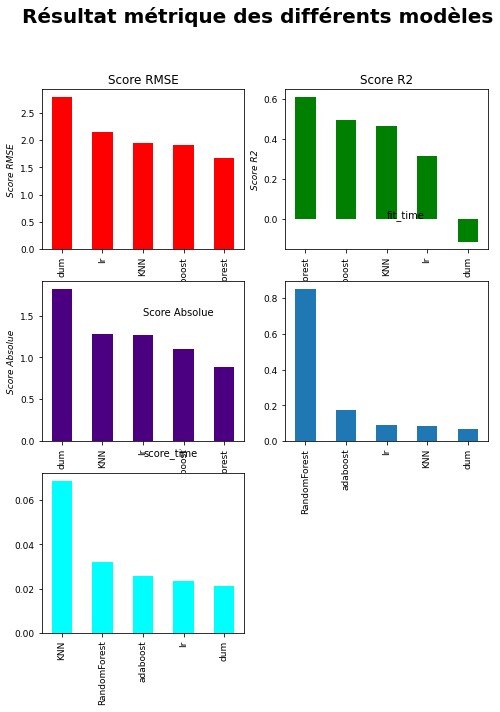

In [33]:
premier = plt.figure(figsize=(8,10))
plt.suptitle('Résultat métrique des différents modèles', 
              fontsize = 20, x = 0.5, y = 0.995,fontweight = 'bold')
plt.subplot(321)
result_un = result_un.sort_values(by='RMSE',ascending = False) 
result_un['RMSE'].plot.bar(rot=90,subplots=True,fontsize=9,color = 'red')
plt.ylabel("Score RMSE",style = 'italic',fontsize=9)
plt.title('Score RMSE')


plt.subplot(322)
result_un = result_un.sort_values(by='R2',ascending = False)
result_un['R2'].plot.bar(rot=90,subplots=True,fontsize=9,color = 'green')
plt.ylabel("Score R2",style = 'italic',fontsize=9)
plt.title('Score R2')

plt.subplot(323)
result_un = result_un.sort_values(by='absolue',ascending = False)
result_un['absolue'].plot.bar(rot=90,subplots=True,fontsize=9,color = 'indigo')
plt.title(' ')
plt.text(2, 1.50, 'Score Absolue')
plt.ylabel('Score Absolue',style = 'italic',fontsize=9)

plt.subplot(324)
result_un = result_un.sort_values(by='fit_time',ascending = False)
result_un['fit_time'].plot.bar(rot=90,subplots=True,fontsize=9)
plt.title(' ')
plt.text(2, 1.25, 'fit_time')


plt.subplot(325)
result_un = result_un.sort_values(by='score_time',ascending = False)
result_un['score_time'].plot.bar(rot=90,subplots=True,fontsize=9,color='cyan')
plt.title(' ')
plt.text(2, 0.08, 'score_time')



les trois meilleurs modèles sont : 
<ul>
<li>Random Forest 
<li>adaboost
<li>KNN
</ul>


#### Optimisation

#### KNN

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [35]:
param_dist = {
              "kNN__algorithm": ['auto','ball_tree','kd_tree','brute'],
              "kNN__leaf_size": randint(25, 40),
              }


# Instantiate a Decision Tree classifier: tree
KNN = Pipeline(steps=[('prepa',preprocessor),('kNN',KNeighborsRegressor())])

# Instantiate the RandomizedSearchCV object: KNN_cv
KNN_cv = RandomizedSearchCV(KNN,param_dist,cv=3,n_iter=40)

# Fit it to the data
result_random_knn = KNN_cv.fit (X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(result_random_knn.best_params_))
print("Best score is {}".format(result_random_knn.best_score_))


Tuned Decision Tree Parameters: {'kNN__algorithm': 'kd_tree', 'kNN__leaf_size': 37}
Best score is 0.4674328892875052


In [36]:
param_dist = {
              "kNN__n_neighbors":randint(2,25)
              }


# Instantiate a Decision Tree classifier: tree
KNN = Pipeline(steps=[('prepa',preprocessor),('kNN',KNeighborsRegressor())])

# Instantiate the RandomizedSearchCV object: KNN_cv
KNN_cv = RandomizedSearchCV(KNN,param_dist,cv=3,n_iter=40)

# Fit it to the data
result_random_knn = KNN_cv.fit (X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(result_random_knn.best_params_))
print("Best score is {}".format(result_random_knn.best_score_))

Tuned Decision Tree Parameters: {'kNN__n_neighbors': 5}
Best score is 0.4674328892875052


In [37]:
KNN = Pipeline(steps=[('prepa',preprocessor),('kNN',KNeighborsRegressor(n_neighbors=7,algorithm='auto',leaf_size=31))])


score = cross_validate(KNN ,X,y,cv=3,scoring=('neg_root_mean_squared_error','r2','neg_mean_absolute_error'))
rmse_knn = -score['test_neg_root_mean_squared_error'].mean()
r2_knn = score['test_r2'].mean()
absolue_knn = -score['test_neg_mean_absolute_error'].mean()
fit_time_knn = score['fit_time'].mean()
score_time_knn = score['score_time'].mean()

In [38]:
result_knn = ([rmse_knn,r2_knn,absolue_knn,score_time_knn])
result_knn_time = ([fit_time_knn])

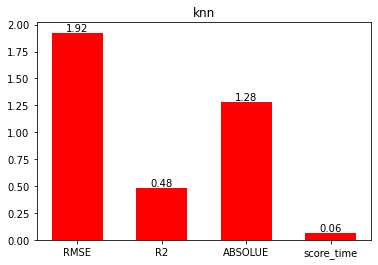

In [39]:
ax = plt.bar(range(4),result_knn,width = 0.6, color = 'red')
plt.xticks(range(4),['RMSE','R2','ABSOLUE','score_time'])
plt.title('knn')
for rect in ax:
       height = rect.get_height()
       height = np.around(height,decimals=2)
       plt.text(rect.get_x() + rect.get_width()/2.0, height,height, ha='center', va='bottom')


In [40]:
result_knn_time

[0.07512100537618001]

#### Adaboost

In [41]:
param_dist = {
              "ADA__learning_rate": randint(1,10),
              "ADA__loss": ['linear', 'square', 'exponential'], 
              }

# Instantiate a Decision Tree classifier: tree
ADA = Pipeline(steps=[('prepa',preprocessor),('ADA',AdaBoostRegressor(random_state=0))])

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(ADA,param_dist,cv=3,n_iter=40)

# Fit it to the data
result_random_ada = tree_cv.fit (X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(result_random_ada.best_params_))
print("Best score is {}".format(result_random_ada.best_score_))


Tuned Decision Tree Parameters: {'ADA__learning_rate': 2, 'ADA__loss': 'linear'}
Best score is 0.46799829329760473


In [42]:
param_dist = {
              "ADA__n_estimators": randint(10, 35), #50 de base
              }

# Instantiate a Decision Tree classifier: tree
ADA = Pipeline(steps=[('prepa',preprocessor),('ADA',AdaBoostRegressor(random_state=0))])

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(ADA,param_dist,cv=3,n_iter=40)

# Fit it to the data
result_random_ada = tree_cv.fit (X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(result_random_ada.best_params_))
print("Best score is {}".format(result_random_ada.best_score_))

Tuned Decision Tree Parameters: {'ADA__n_estimators': 20}
Best score is 0.5189682881952659


In [43]:
ada = Pipeline(steps=[('prepa',preprocessor),('ADA',AdaBoostRegressor(n_estimators=20, learning_rate=3, loss='exponential'
                                                                       ))])


score = cross_validate(ada,X,y,cv=3,scoring=('neg_root_mean_squared_error','r2','neg_mean_absolute_error'))
rmse_ada = -score['test_neg_root_mean_squared_error'].mean()
r2_ada = score['test_r2'].mean()
absolue_ada = -score['test_neg_mean_absolute_error'].mean()
fit_time_ada = score['fit_time'].mean()
score_time_ada = score['score_time'].mean()

In [44]:
result_ada = ([rmse_ada,r2_ada,absolue_ada,score_time_ada])
result_ada_time = ([fit_time_ada])

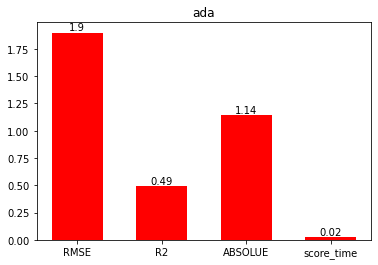

In [45]:
test = plt.bar(range(4),result_ada,width = 0.6, color = 'red')
plt.xticks(range(4),['RMSE','R2','ABSOLUE','score_time'])
plt.title('ada')
for rect in test:
       height = rect.get_height()
       height = np.around(height,decimals=2)
       plt.text(rect.get_x() + rect.get_width()/2.0, height,height, ha='center', va='bottom')

#### Random forest 

In [46]:
param_dist = {
              "forest__min_samples_leaf": randint(1, 9), #2 de base
              "forest__bootstrap":("true","false")
              }

# Instantiate a Decision Tree classifier: tree
forest = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(random_state=0))])

# Instantiate the RandomizedSearchCV object: tree_cv
forest_cv = RandomizedSearchCV(forest,param_dist,cv=3,n_iter=40)

# Fit it to the data
forest_cv = forest_cv.fit (X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_))

Tuned Decision Tree Parameters: {'forest__bootstrap': 'false', 'forest__min_samples_leaf': 1}
Best score is 0.6295639558803019


In [47]:
param_dist = {"forest__n_estimators" : randint(80, 160) #100 de base
              }

# Instantiate a Decision Tree classifier: tree
forest = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(random_state=0))])

# Instantiate the RandomizedSearchCV object: tree_cv
forest_cv = RandomizedSearchCV(forest,param_dist,cv=3,n_iter=40)

# Fit it to the data
forest_cv = forest_cv.fit (X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_))

Tuned Decision Tree Parameters: {'forest__n_estimators': 135}
Best score is 0.6361102016031207


In [48]:
forest_max = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(n_estimators=134,bootstrap="True",
                                                                               min_samples_leaf=1
                                                                              ))])

score = cross_validate(forest_max,X,y,cv=3,scoring=('neg_root_mean_squared_error','r2','neg_mean_absolute_error'))
rmse_forest = -score['test_neg_root_mean_squared_error'].mean()
r2_forest = score['test_r2'].mean()
absolue_forest = -score['test_neg_mean_absolute_error'].mean()
fit_time_forest = score['fit_time'].mean()
score_time_forest = score['score_time'].mean()

In [49]:
result_forest = ([rmse_forest,r2_forest,absolue_forest,score_time_forest])
result_forest_time = ([fit_time_forest])

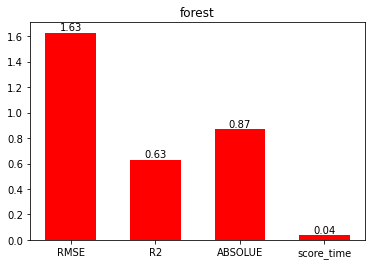

In [50]:
test = plt.bar(range(4),result_forest,width = 0.6, color = 'red')
plt.xticks(range(4),['RMSE','R2','ABSOLUE','score_time'])
plt.title('forest')
for rect in test:
       height = rect.get_height()
       height = np.around(height,decimals=2)
       plt.text(rect.get_x() + rect.get_width()/2.0, height,height, ha='center', va='bottom')

In [51]:
result_forest_time

[1.1336325804392497]

#### Comparaison des 3 modèles

In [52]:
result_knn = pd.DataFrame(result_knn)
result_knn = result_knn.rename({0: "KNN"},axis='columns')
result_ada = pd.DataFrame(result_ada)
result_ada = result_ada.rename({0: "adaboost"},axis='columns')
result_forest = pd.DataFrame(result_forest)
result_forest = result_forest.rename({0: "RandomForest"},axis='columns')


result_deux = pd.concat([result_knn,result_ada,result_forest],axis=1)
result_deux  = result_deux.rename({0: "RMSE_apres", 1: "R2_apres",2: "absolue_apres",3:"score_time_apres"}, axis='index')


In [53]:
result_deux

,KNN,adaboost,RandomForest
RMSE_apres,1.923662,1.897543,1.626998
R2_apres,0.480877,0.494110,0.629567
absolue_apres,1.277812,1.140627,0.872354
score_time_apres,0.060515,0.022605,0.036921


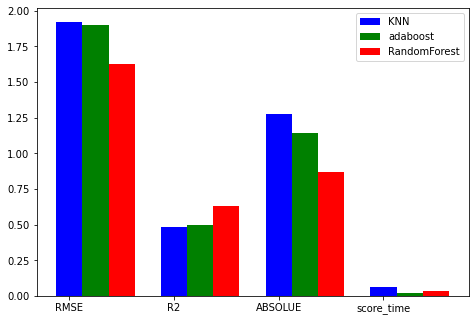

In [54]:
data = result_deux 
x = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(x + 0.00, data['KNN'], color = 'b', width = 0.25)
rects2 = ax.bar(x + 0.25, data['adaboost'], color = 'g', width = 0.25)
rects3 = ax.bar(x + 0.50, data['RandomForest'], color = 'r', width = 0.25)

plt.xticks(range(0, 4),['RMSE','R2','ABSOLUE','score_time'])
ax.legend(labels=['KNN', 'adaboost','RandomForest'])


In [55]:
result_time = ([result_knn_time,result_ada_time,result_forest_time])
result_time = pd.DataFrame(result_time)
result_time = result_time.rename({0: "fit_time"},axis='columns')
result_time = result_time.rename({0: "knn",1:"ada",2:"forest"},axis='index')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000012B4440DF10>],
      dtype=object)

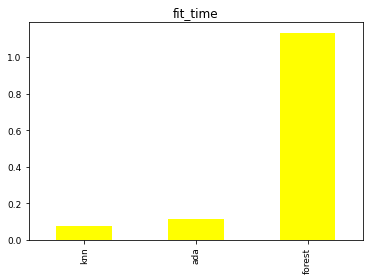

In [57]:
result_time['fit_time'].plot.bar(rot=90,subplots=True,fontsize=9,color = 'yellow')

#### comparaison avant et après amélioration des paramètres

In [58]:
result_un = result_un.drop(['dum','lr'],axis=0)
result_un = result_un.drop(['score_time'],axis=1)

In [59]:
result_deux = result_deux.T

In [60]:
result_un

,RMSE,R2,absolue,fit_time
KNN,1.951725,0.462350,1.274382,0.084128
RandomForest,1.667496,0.612374,0.885313,0.852375
adaboost,1.909478,0.493304,1.101464,0.173214


In [61]:
result_comparaison = pd.concat([result_un,result_deux],axis=1)

In [62]:
result_comparaison

,RMSE,R2,absolue,fit_time,RMSE_apres,R2_apres,absolue_apres,score_time_apres
KNN,1.951725,0.462350,1.274382,0.084128,1.923662,0.480877,1.277812,0.060515
RandomForest,1.667496,0.612374,0.885313,0.852375,1.626998,0.629567,0.872354,0.036921
adaboost,1.909478,0.493304,1.101464,0.173214,1.897543,0.494110,1.140627,0.022605


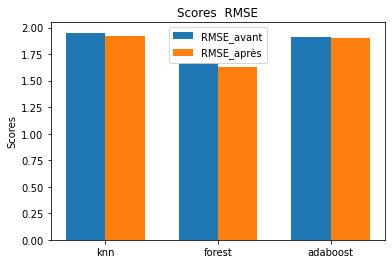

In [65]:
labels = ['knn', 'forest', 'adaboost']
rmse = result_comparaison['RMSE']
rmse_apres = result_comparaison['RMSE_apres']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rmse, width, label='RMSE_avant')
rects2 = ax.bar(x + width/2, rmse_apres, width, label='RMSE_après')

ax.set_ylabel('Scores')
ax.set_title('Scores  RMSE')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

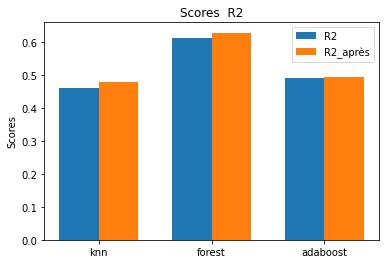

In [66]:
labels = ['knn', 'forest', 'adaboost']
rmse = result_comparaison['R2']
rmse_apres = result_comparaison['R2_apres']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rmse, width, label='R2')
rects2 = ax.bar(x + width/2, rmse_apres, width, label='R2_après')

ax.set_ylabel('Scores')
ax.set_title('Scores  R2')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

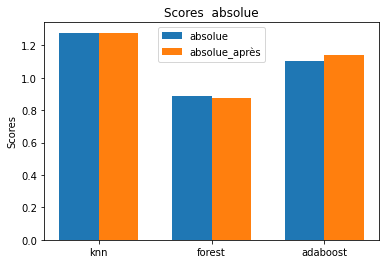

In [67]:
labels = ['knn', 'forest', 'adaboost']
rmse = result_comparaison['absolue']
rmse_apres = result_comparaison['absolue_apres']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rmse, width, label='absolue')
rects2 = ax.bar(x + width/2, rmse_apres, width, label='absolue_après')

ax.set_ylabel('Scores')
ax.set_title('Scores  absolue')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

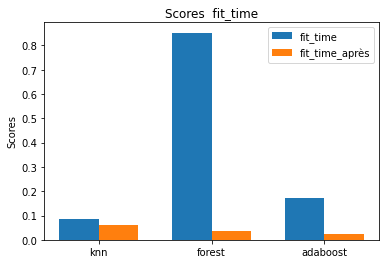

In [68]:
labels = ['knn', 'forest', 'adaboost']
rmse = result_comparaison['fit_time']
rmse_apres = result_comparaison['score_time_apres']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rmse, width, label='fit_time')
rects2 = ax.bar(x + width/2, rmse_apres, width, label='fit_time_après')

ax.set_ylabel('Scores')
ax.set_title('Scores  fit_time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#### Courbes d'apprentissage

[ 89 179 269 359 449 538 628 718 808 898]


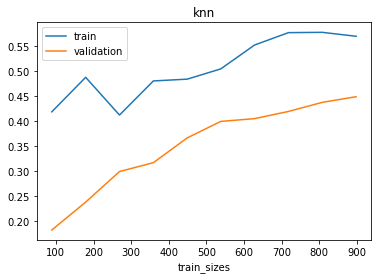

In [70]:
from sklearn.model_selection import learning_curve
KNN = Pipeline(steps=[('prepa',preprocessor),('kNN',KNeighborsRegressor(n_neighbors=7,algorithm='auto',leaf_size=31))])

N, train_score, val_score = learning_curve(KNN, X_train, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=3)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('knn')
plt.legend()

[ 89 179 269 359 449 538 628 718 808 898]


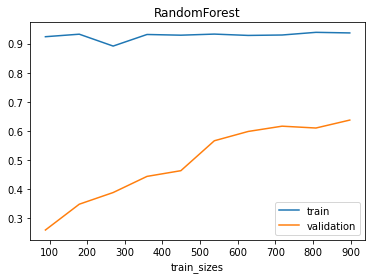

In [71]:
from sklearn.model_selection import learning_curve
forest = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(n_estimators=134,bootstrap="False",
                                                                               min_samples_leaf=1
                                                                              ))])

N, train_score, val_score = learning_curve(forest, X_train, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=3)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('RandomForest')
plt.legend()

[ 89 179 269 359 449 538 628 718 808 898]


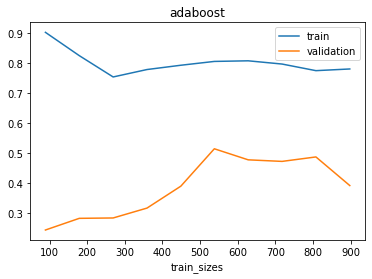

In [72]:
from sklearn.model_selection import learning_curve
ada = Pipeline(steps=[('prepa',preprocessor),('ADA',AdaBoostRegressor(n_estimators=20, learning_rate=3, loss='exponential'
                                                                       ))])

N, train_score, val_score = learning_curve(ada, X_train, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=3)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('adaboost')
plt.legend()

#### Meilleurs variables pour Random forest

#### les meilleurs features pour Random forest

In [ ]:
nom = []
feature = []
from sklearn.inspection import permutation_importance
r = permutation_importance(forest_max, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            nom.append([
            X.columns[i]])
            feature.append([
            r.importances_mean[i]])  

In [74]:
nom = pd.DataFrame(nom)
nom = nom.rename({0: "nom"},axis='columns')
feature = pd.DataFrame(feature)
feature = feature.rename({0: "feature"},axis='columns')
best_features = pd.concat([nom,feature],axis=1)
best_features = best_features.set_index('nom')

Text(0.5, 1.0, 'score features')

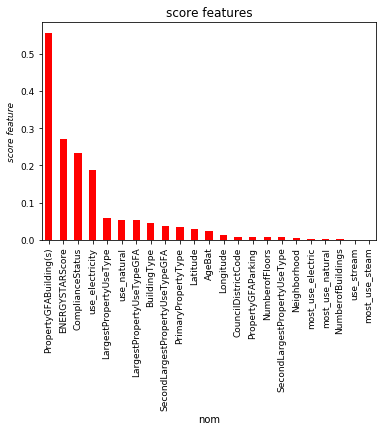

In [75]:
best_features['feature'].plot.bar(rot=90,subplots=True,fontsize=9,color = 'blue')
plt.ylabel("score feature",style = 'italic',fontsize=9)
plt.title('score features')

#### Creer un dataset avec les meilleurs features

In [80]:
columns = ["PropertyGFABuilding(s)","ComplianceStatus","use_electricity","LargestPropertyUseType",
           "LargestPropertyUseTypeGFA","use_natural","BuildingType","PrimaryPropertyType",
           "SiteEnergyUse(kBtu)_log","ENERGYSTARScore"] 
# enlerver ENERGYSTARScore (si on veut voir le score sans)
# changer la targuet SiteEnergyUse(kBtu)_log / TotalGHGEmissions_log (si on veut voir l'autre targuet)

df_final = pd.DataFrame(df_final, columns=columns)

In [81]:
X = df_final.drop(['SiteEnergyUse(kBtu)_log'],axis=1) ## 
y = df_final['SiteEnergyUse(kBtu)_log']

col_int =  list(X.columns[X.dtypes == 'int64'])
col_float = list(X.columns[X.dtypes == 'float64'])
col_cate = list(X.columns[X.dtypes == 'object'])


col_int_tr = Pipeline(steps = [
   ('imputer', SimpleImputer(strategy = 'most_frequent')),
   ('scaler', StandardScaler())])

col_float_tr = Pipeline(steps = [
   ('imputer', SimpleImputer(strategy = 'most_frequent')),
   ('scaler', StandardScaler())])

col_cate_tr = Pipeline(steps = [
   ('imputer', SimpleImputer(strategy = 'most_frequent')),
   ('lab_enc', BinaryEncoder())])

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
   transformers=[
       ('ints', col_int_tr, col_int),
       ('cont', col_float_tr, col_float),
       ('cat', col_cate_tr, col_cate)])

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0)

print('train set: ', X_train.shape)
print('test set: ', X_test.shape)

train set:  (1348, 9)
test set:  (337, 9)


#### Evaluation finale

In [84]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


forest = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(n_estimators=134,bootstrap="False",
                                                                               min_samples_leaf=1
                                                                              ))])

# Fit it to the data
forest = forest.fit (X_train, y_train)
y_pred = forest.predict(X_test)

forest.score(X_test, y_test)

print("rmse: ",mean_squared_error(y_test, y_pred, squared=False))
print("R2: ",r2_score(y_test, y_pred))


rmse:  1.8885660382511082
R2:  0.6624590451415628
